In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [54]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction_for_coupled_momentum_model

from project_ssms.coupled_momentum_observation import CoupledMomentumObservation
from project_ssms.coupled_momentum_observation import CoupledMomemtumTransformation
from project_ssms.feature_funcs import feature_func_single
from project_ssms.momentum_utils import filter_traj_by_speed

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# data

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

session_data = datasets_processed[0].render_trajectories([3,8])
traj0 = np.concatenate((session_data), axis=1)

In [4]:
f_traj = filter_traj_by_speed(traj0, q1=0.99, q2=0.99)

In [57]:
arena_xmin = 10
arena_xmax = 320

arena_ymin = -10
arena_ymax = 390

WATER = torch.tensor([50, 50], dtype=torch.float64)
FOOD = torch.tensor([270, 50], dtype=torch.float64)
NEST = torch.tensor([270, 330], dtype=torch.float64)
CORNER = torch.tensor([50, 330], dtype=torch.float64)

# momentum-feature model

$$ x_t \sim x_{t-1} +  2 * \sigma(\alpha_k) m_t + v_{max} \sigma(W_k f(x_{t-1}, x'_{t-1}) + b_k))  \qquad | \qquad z_t =k$$ 

where

- $m_t$ is the momentum vector, obtained by applying a (weighted) linear regression to the past #lags observations, and scaling the fitted vector by 1/#lags.
- $v_{max}$ = 6
- features here are:
     - unit_vector_to_other,
     - lambda s, o: unit_vector_to_fixed_loc(s, o, WATER),
     - lambda s, o: unit_vector_to_fixed_loc(s, o, NEST),
     - lambda s, o: unit_vector_to_fixed_loc(s, o, FOOD),
     - lambda s, o: unit_vector_to_fixed_loc(s, o, CORNER),


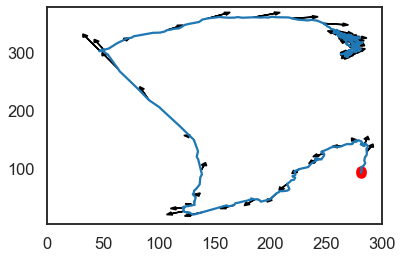

In [183]:
plt.plot(data[14000:15000,0].numpy(), data[14000:15000,1].numpy())

for t in np.arange(14010, 15000, 10):
    plt.arrow(data[t, 0].numpy(), data[t, 1].numpy(),
             5*momentum_vecs[t,0].numpy(), 5*momentum_vecs[t,1].numpy(),
             color='black', head_width=5, head_length=5)
   
    #plt.arrow(data[t, 2].numpy(), data[t, 3].numpy(),
     #        5*momentum_vecs[t,2].numpy(), 5*momentum_vecs[t,3].numpy(),
      #       color='black', head_width=5, head_length=5)
    
plt.scatter(data[14000:14002,0].numpy(), data[14000:14002,1].numpy(), color='red')

#plt.plot(data[14000:15000,2].numpy(), data[14000:15000,3].numpy())

#plt.scatter(data[14000:14002,2].numpy(), data[14000:14002,3].numpy(), color='red')

plt.xlim(0, 300);

In [169]:
data.min(dim=0)

torch.return_types.min(
values=tensor([30.2948,  6.8702, 17.6302, -1.4333], dtype=torch.float64),
indices=tensor([ 6473, 20803, 35056,  7601]))

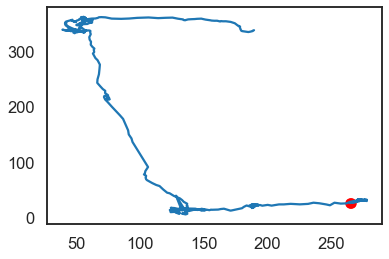

In [166]:
plt.plot(data[14000:14500,2].numpy(), data[14000:14500,3].numpy())

plt.scatter(data[14000:14002,2].numpy(), data[14000:14002,3].numpy(), color='red')

In [6]:
data = torch.tensor(f_traj, dtype=torch.float64)

#### check momentum first

In [38]:
momentum_lags = 30
momentum_weights = np.arange(0.55, 2.05, 0.05)

In [39]:
momentum_weights

array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  ])

In [40]:
momentum_vecs = CoupledMomemtumTransformation._compute_momentum_vecs(data[:-1],
                                                                     lags=momentum_lags, 
                                                                     weights=momentum_weights)

In [41]:
momentum_vecs.shape

torch.Size([35999, 4])

## build the model

In [43]:
torch.manual_seed(0)
np.random.seed(0)

bounds = np.array([[arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5], 
                   [arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5]])

max_v = np.array([5.0, 5.0, 5.0, 5.0])

acc_factor=2


In [44]:
K = 4
D = 4
Df = 10
T = 36000

In [45]:
observation = CoupledMomentumObservation(K=K, D=D, M=0, 
                                         momentum_lags=momentum_lags,momentum_weights=momentum_weights,
                                         Df=Df, feature_func=feature_func_single, bounds=bounds, 
                                         max_v=max_v, acc_factor=acc_factor)

model = HMM(K=K, D=D, M=0, observation=observation)

In [51]:
m_tran = model.observation.transformation

In [46]:
model.log_likelihood(data)

tensor(-630891.1701, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

#### before trainin, how does the dynamics look like.

In [47]:
XX, YY = np.meshgrid(np.linspace(0, 320, 30), 
                     np.linspace(0, 370, 30))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (900,2) grid values

In [48]:
def get_XY_other(pos, shape=(900,1)):
    return np.tile(pos[None,], shape)

In [68]:
XY_other = get_XY_other(np.array([320/2, 370/2]))
XY_virgin = np.concatenate((XY, XY_other), axis=1)
XY_mother = np.concatenate((XY_other, XY), axis=1)

In [69]:
momentum_vec_0 = torch.tensor([-1, -1, 0, 0], dtype=torch.float64) # (4, )
quiver_momentum_vecs_0 = momentum_vec_0 * torch.ones(900, 1, dtype=torch.float64)

In [70]:
XY_virgin_next_0 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_0)
dXY_virgin_0 = XY_virgin_next_0.detach().numpy() - XY_virgin[:, None]

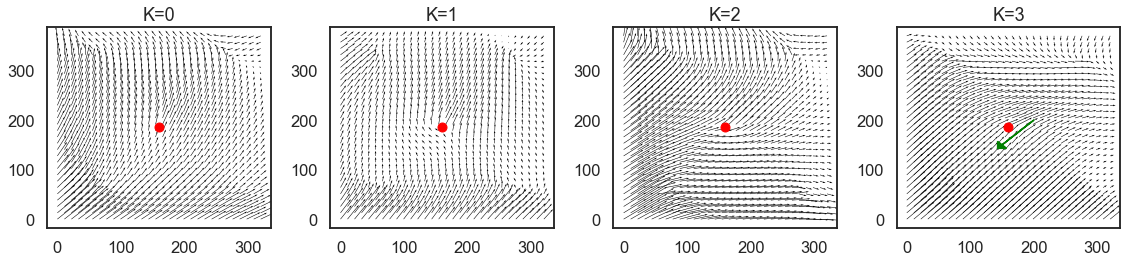

In [71]:
plot_quiver(XY_virgin, dXY_virgin_0, 'virgin', [320/2, 370/2], scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20)

In [72]:
XY_other = get_XY_other(NEST)
XY_virgin = np.concatenate((XY, XY_other), axis=1)
XY_mother = np.concatenate((XY_other, XY), axis=1)

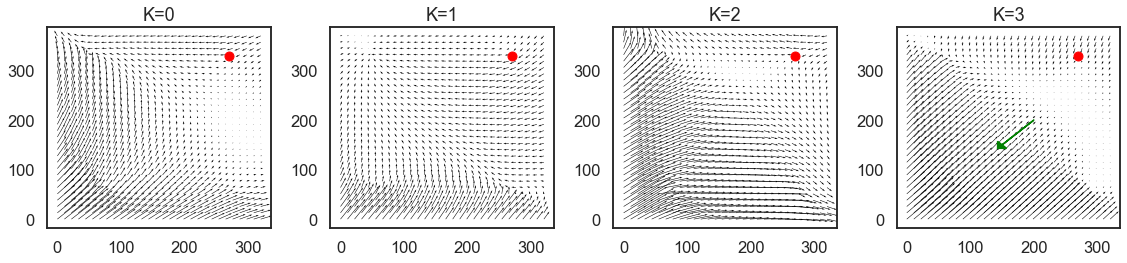

In [73]:
XY_virgin_next_0 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_0)
dXY_virgin_0 = XY_virgin_next_0.detach().numpy() - XY_virgin[:, None]
plot_quiver(XY_virgin, dXY_virgin_0, 'virgin', NEST, scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20);

# training

In [75]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [78]:
features = CoupledMomemtumTransformation._compute_features(m_tran.feature_funcs, data[:-1])

In [79]:
##################### training ############################

num_iters = 5000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.005, momentum_vecs=momentum_vecs, features=features)

iter 4990 loss 208514.29: 100%|██████████| 5000/5000 [45:12<00:00,  2.34it/s] | 0/5000 [00:00<?, ?it/s]


In [80]:
z = model.most_likely_states(data)

In [81]:
x_predict = k_step_prediction_for_coupled_momentum_model(model, z, data, momentum_vecs=momentum_vecs, features=features)

([], <a list of 0 Text yticklabel objects>)

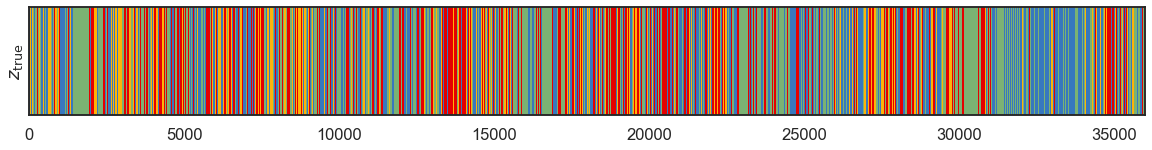

In [82]:
plt.figure(figsize=(20,2))
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

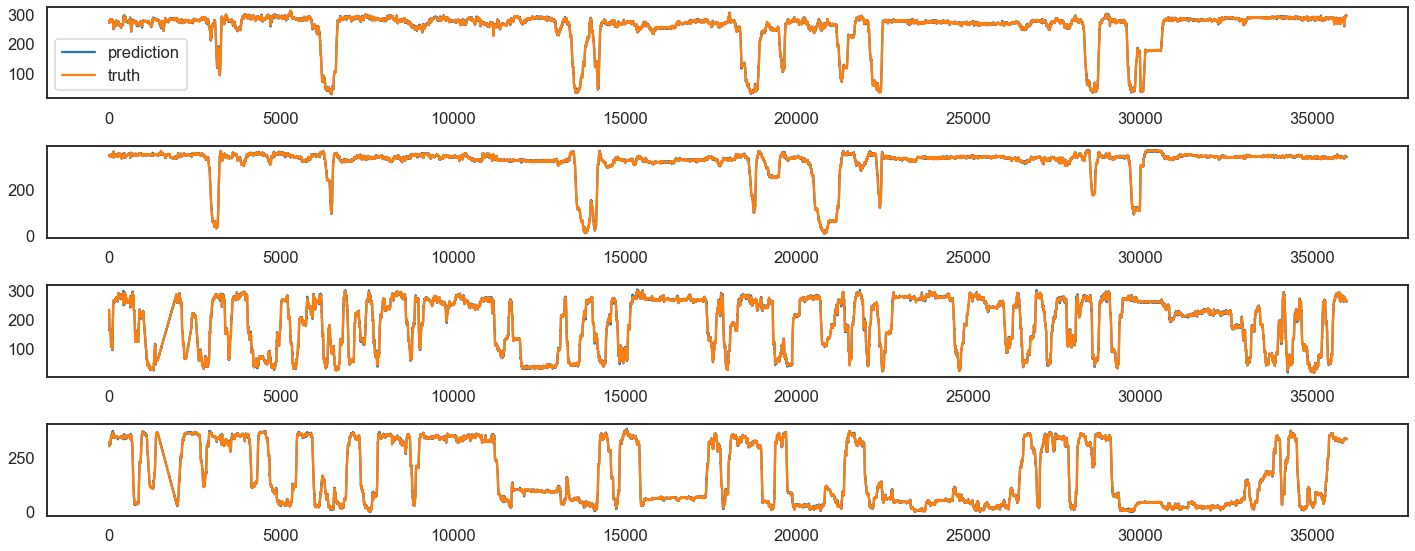

In [83]:
plt.figure(figsize=(20,8))

plt.subplot(4,1,1)
plt.plot(x_predict[:,0], label='prediction')
plt.plot(data[:,0].numpy(), label='truth')
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_predict[:,1], label='prediction')
plt.plot(data[:,1].numpy(), label='truth')

plt.subplot(4,1,3)
plt.plot(x_predict[:,2], label='prediction')
plt.plot(data[:,2].numpy(), label='truth')

plt.subplot(4,1,4)
plt.plot(x_predict[:,3], label='prediction')
plt.plot(data[:,3].numpy(), label='truth')

plt.tight_layout()

In [84]:
z_num = [sum(z==k) for k in range(K)]
z_num

[11158, 8808, 5314, 10720]

# samples

In [109]:
center = torch.tensor([150, 170, 150, 170], dtype=torch.float64)

In [108]:
model.observation.mus_init = torch.tensor([150, 170, 150, 170], dtype=torch.float64)

In [90]:
sample_z, sample_x = model.sample(T)

In [91]:
[sum(sample_z == k) for k in range(K)]

[11168, 8710, 5569, 10553]

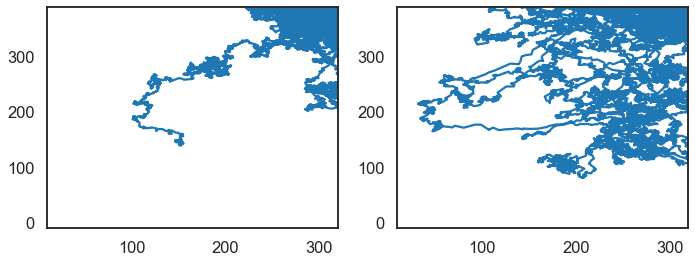

In [97]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(sample_x[:,0], sample_x[:,1])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
plt.subplot(1,2,2)
plt.plot(sample_x[:,2], sample_x[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)

plt.tight_layout()

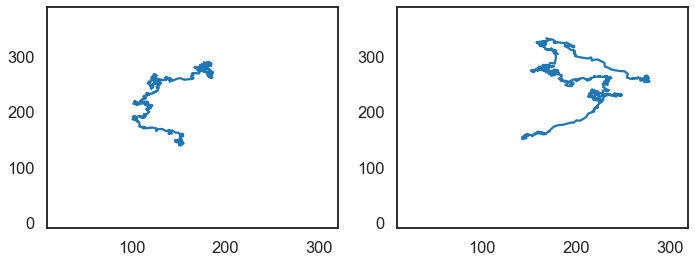

In [101]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(sample_x[:1000,0], sample_x[:1000,1])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
plt.subplot(1,2,2)
plt.plot(sample_x[:1000,2], sample_x[:1000,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)

plt.tight_layout()

In [158]:
momentum_vecs_sample = CoupledMomemtumTransformation._compute_momentum_vecs(torch.tensor(sample_x[:-1], dtype=torch.float64),
                                                                     lags=momentum_lags, 
                                                                     weights=momentum_weights)

(10, 320)

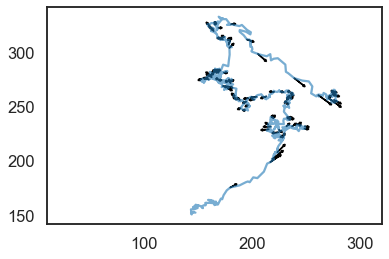

In [159]:
plt.plot(sample_x[0:1000,2], sample_x[0:1000,3], alpha=0.6)

for t in np.arange(50, 1000, 10):
    plt.arrow(sample_x[t, 2], sample_x[t, 3],
             5*momentum_vecs_sample[t,2].numpy(), 5*momentum_vecs_sample[t,3].numpy(),
             color='black', head_width=2, head_length=2)
    
plt.xlim(arena_xmin, arena_xmax)

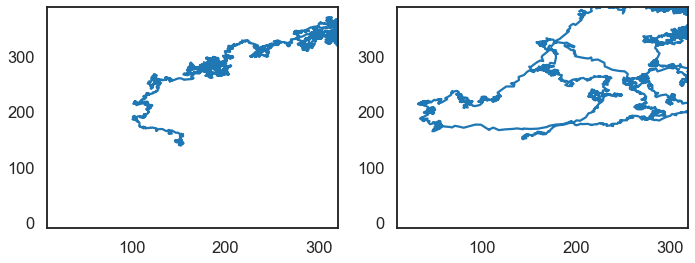

In [100]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(sample_x[:5000,0], sample_x[:5000,1])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
plt.subplot(1,2,2)
plt.plot(sample_x[:5000,2], sample_x[:5000,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)

plt.tight_layout()

# dynamics

#### 1. Condition on fix z sequence (say z = [1,1,1,....,1,1,]), see how the sampled observations look like.

In [119]:
fix_t = 1000
fix_z0 = np.zeros(fix_t)
fix_z1 = np.ones(fix_t)
fix_z2 = 2 * np.ones(fix_t)
fix_z3 = 3 * np.ones(fix_t)

In [120]:
sample_z0 = model.sample_condition_on_zs(zs=fix_z0, x0=data[0])
sample_z1 = model.sample_condition_on_zs(zs=fix_z1, x0=data[0])
sample_z2 = model.sample_condition_on_zs(zs=fix_z2, x0=data[0])
sample_z3 = model.sample_condition_on_zs(zs=fix_z3, x0=data[0])


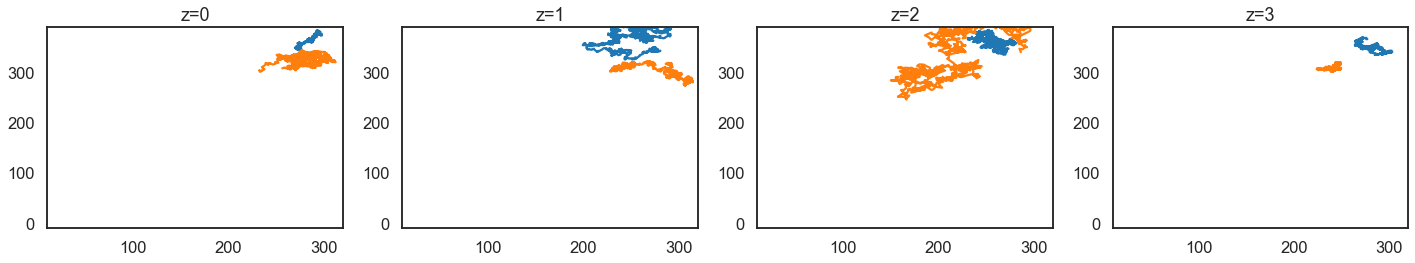

In [121]:
plt.figure(figsize=(20, 4))

ax1 = plt.subplot(1,4,1)
plt.plot(sample_z0[:,0], sample_z0[:,1])
plt.plot(sample_z0[:,2], sample_z0[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
ax1.set_title("z=0")

ax2 = plt.subplot(1,4,2)
plt.plot(sample_z1[:,0], sample_z1[:,1])
plt.plot(sample_z1[:,2], sample_z1[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
ax2.set_title("z=1")

ax3 = plt.subplot(1,4,3)
plt.plot(sample_z2[:,0], sample_z2[:,1])
plt.plot(sample_z2[:,2], sample_z2[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
ax3.set_title("z=2")

ax4 = plt.subplot(1,4,4)
plt.plot(sample_z3[:,0], sample_z3[:,1])
plt.plot(sample_z3[:,2], sample_z3[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
ax4.set_title("z=3")

plt.tight_layout()

#### 2. quiver plots

In [134]:
momentum_vec_0 = torch.tensor([-1, -1, 0, 0], dtype=torch.float64) # (4, )

In [141]:
def get_quiver_args(other_pos, momentum_vec):
    quiver_momentum_vecs = momentum_vec * torch.ones(900, 1, dtype=torch.float64)
    XY_other = get_XY_other(other_pos)
    XY_virgin = np.concatenate((XY, XY_other), axis=1)
    #XY_mother = np.concatenate((XY_other, XY), axis=1)
    
    XY_virgin_next = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs)
    dXY_virgin = XY_virgin_next.detach().numpy() - XY_virgin[:, None]
    
    return XY_virgin, dXY_virgin

In [149]:
XY_virgin_nest, dXY_virgin_nest_0 = get_quiver_args(NEST, momentum_vec_0)                                                                            

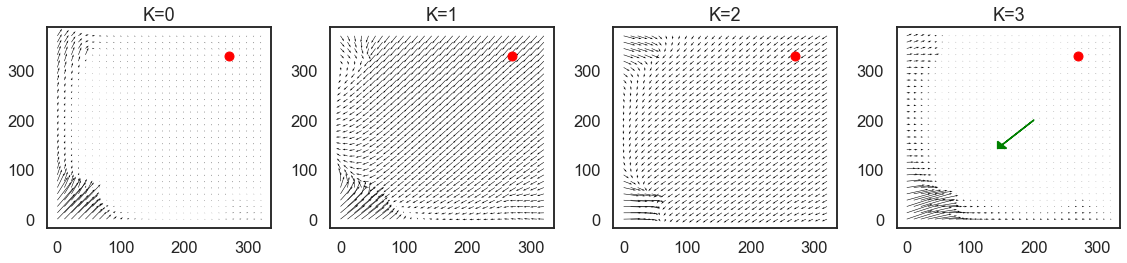

In [143]:
plot_quiver(XY_virgin_nest, dXY_virgin_nest_0, 'virgin', NEST, scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20);

In [148]:
XY_virgin_water, dXY_virgin_water_0 = get_quiver_args(WATER, momentum_vec_0)                                                                            

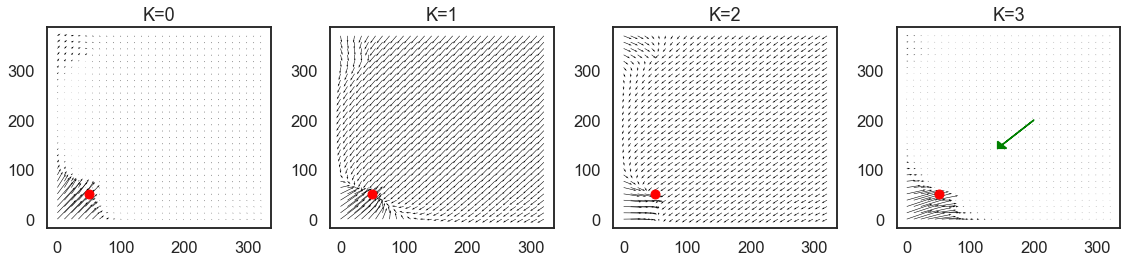

In [145]:
plot_quiver(XY_virgin, dXY_virgin_0, 'virgin', WATER, scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20);

In [129]:
momentum_vec_1 = torch.tensor([1, 1, 0, 0], dtype=torch.float64) # (4, )

In [153]:
XY_virgin_nest, dXY_virgin_nest_1 = get_quiver_args(NEST, momentum_vec_1)

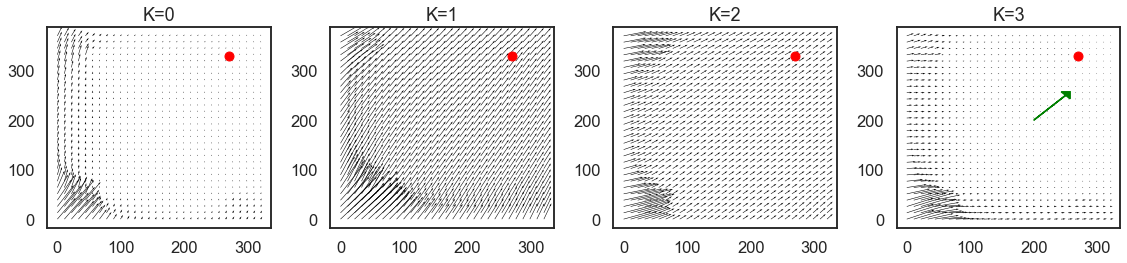

In [155]:
plot_quiver(XY_virgin_nest, dXY_virgin_nest_1, 'virgin', NEST, scale=0.1)
plt.arrow(200, 200, 50, 50, color='green', head_length = 10, head_width = 20)

In [156]:
XY_virgin_water, dXY_virgin_water_1 = get_quiver_args(WATER, momentum_vec_1)

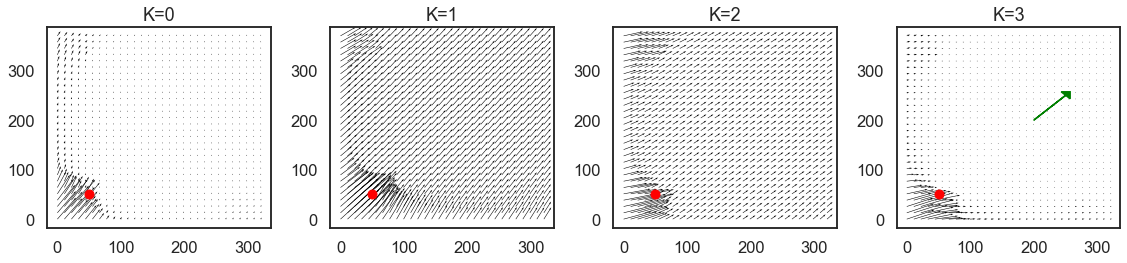

In [157]:
plot_quiver(XY_virgin_water, dXY_virgin_water_1, 'virgin', WATER, scale=0.1)
plt.arrow(200, 200, 50, 50, color='green', head_length = 10, head_width = 20);

In [160]:
torch.exp(model.observation.log_sigmas)

tensor([[0.5166, 0.5133, 1.4737, 1.4198],
        [1.6234, 1.7510, 1.0101, 0.9754],
        [1.2623, 1.3338, 3.1096, 3.1192],
        [0.6229, 0.5956, 0.4922, 0.4500]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

## dynamics introduced by the features

In [171]:
m_tran.Ws.shape

torch.Size([4, 4, 10])

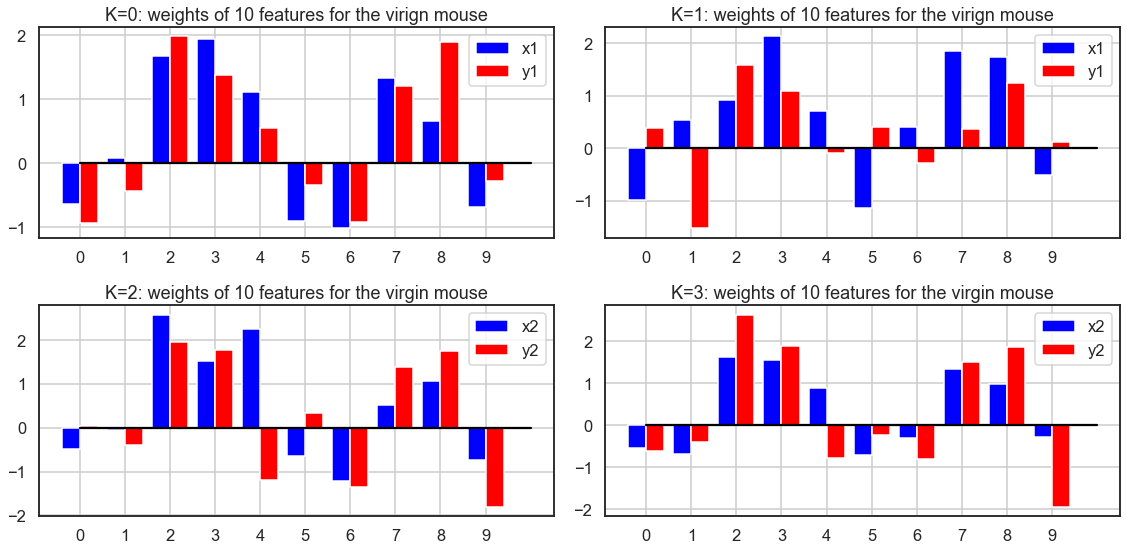

In [173]:
plt.figure(figsize=(16, 8))

plt.subplot(2,2,1)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[0][0].detach().numpy(), width=.4, color='b', label='x1')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[0][1].detach().numpy(), width=.4, color='r', label='y1')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=0: weights of 10 features for the virign mouse")

plt.subplot(2,2,2)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[1][0].detach().numpy(), width=.4, color='b', label='x1')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[1][1].detach().numpy(), width=.4, color='r', label='y1')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=1: weights of 10 features for the virign mouse")

plt.subplot(2,2,3)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[2][0].detach().numpy(), width=.4, color='b', label='x2')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[2][1].detach().numpy(), width=.4, color='r', label='y2')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=2: weights of 10 features for the virgin mouse")

plt.subplot(2,2,4)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[3][0].detach().numpy(), width=.4, color='b', label='x2')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[3][1].detach().numpy(), width=.4, color='r', label='y2')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=3: weights of 10 features for the virgin mouse")

plt.tight_layout()

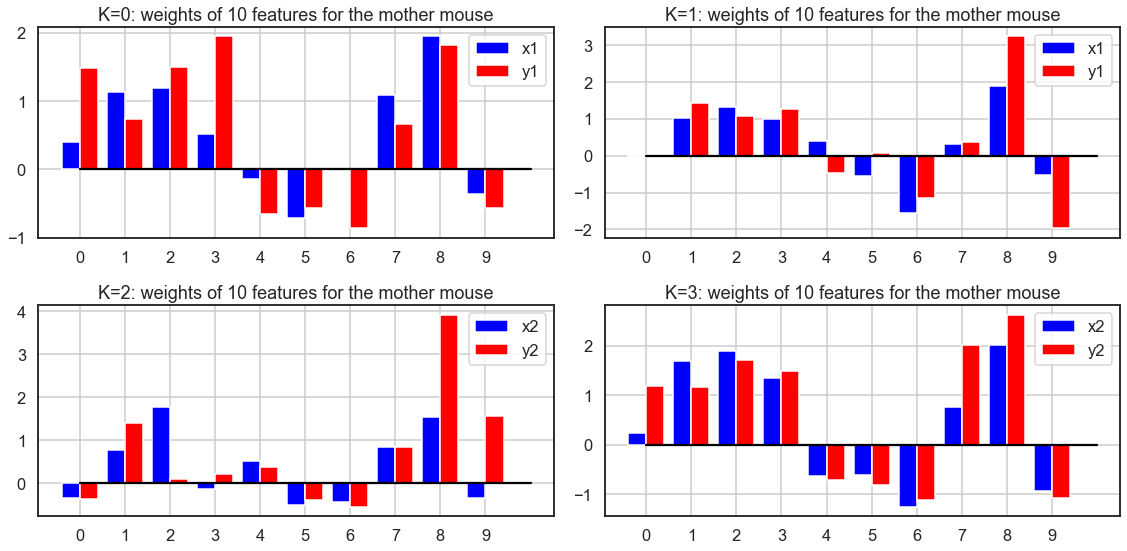

In [174]:
plt.figure(figsize=(16, 8))

plt.subplot(2,2,1)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[0][2].detach().numpy(), width=.4, color='b', label='x1')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[0][3].detach().numpy(), width=.4, color='r', label='y1')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=0: weights of 10 features for the mother mouse")

plt.subplot(2,2,2)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[1][2].detach().numpy(), width=.4, color='b', label='x1')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[1][3].detach().numpy(), width=.4, color='r', label='y1')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=1: weights of 10 features for the mother mouse")

plt.subplot(2,2,3)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[2][2].detach().numpy(), width=.4, color='b', label='x2')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[2][3].detach().numpy(), width=.4, color='r', label='y2')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=2: weights of 10 features for the mother mouse")

plt.subplot(2,2,4)
plt.bar(np.arange(10) - 0.2, m_tran.Ws[3][2].detach().numpy(), width=.4, color='b', label='x2')
plt.bar(np.arange(10) + 0.2, m_tran.Ws[3][3].detach().numpy(), width=.4, color='r', label='y2')
plt.plot([0, 10], [0, 0], '-k')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.legend()
plt.title("K=3: weights of 10 features for the mother mouse")

plt.tight_layout()

the first feature has little influence for $K=1,2$, and similar effect for $K=0,3$.